<a href="https://colab.research.google.com/github/Ayushichadha/multiLayerPerceptron/blob/main/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We implement a multilayer perceptron (MLP) character-level language model and work on many basics of machine learning (e.g. model training, learning rate tuning, hyperparameters, evaluation, train/dev/test splits, under/overfitting, etc.).

In [ ]:
# Bengio et al. 2003 (MLP language model) paper
# implementing the embedding lookup table
# implementing the hidden layer + internals of torch.Tensor: storage, views
# implementing the output layer
# implementing the negative log likelihood loss
# introducing F.cross_entropy
# implementing the training loop, overfitting one batch
# training on the full dataset, minibatches
# finding a good initial learning rate
# splitting up the dataset into train/val/test splits and why
# experiment: larger hidden layer
# visualizing the character embeddings
# experiment: larger embedding size
# sampling from the model

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-08-01 17:05:30--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2025-08-01 17:05:30 (8.58 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [ ]:
len(words)

32033

In [ ]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


**Writing neural network**

implementing embedding lookup table

In [ ]:
C = torch.randn((27, 2))

In [ ]:
C[5]

tensor([-0.1749, -0.2777])

Pytorch Indexing

In [ ]:
#indexing with a list
C[[5,6,7]]

tensor([[-0.1749, -0.2777],
        [-1.8644,  2.0524],
        [-0.7870, -0.7060]])

In [ ]:
#indexing with tensor
C[torch.tensor([5,6,7])]

tensor([[-0.1749, -0.2777],
        [-1.8644,  2.0524],
        [-0.7870, -0.7060]])

In [ ]:
#multidimensional indexing --> X:[32,3], C:[27,2]
# C[X] --> [32,3,2] where [32,3] is the original shape and 2 is dimension of embeddings.
C[X].shape

torch.Size([228146, 3, 2])

In [ ]:
C[X]

tensor([[[-0.6907,  0.3771],
         [-0.6907,  0.3771],
         [-0.6907,  0.3771]],

        [[-0.6907,  0.3771],
         [-0.6907,  0.3771],
         [-0.1749, -0.2777]],

        [[-0.6907,  0.3771],
         [-0.1749, -0.2777],
         [-0.3704, -0.4016]],

        ...,

        [[ 0.5591,  0.0443],
         [ 0.5591,  0.0443],
         [-1.5278,  1.2984]],

        [[ 0.5591,  0.0443],
         [-1.5278,  1.2984],
         [ 0.5591,  0.0443]],

        [[-1.5278,  1.2984],
         [ 0.5591,  0.0443],
         [-1.5812, -0.2508]]])

In [ ]:
X[13,2]

tensor(1)

In [ ]:
C[X][13,2]  #gives the embedding vector of element at [13,2] in X i.e. of 1.

tensor([-0.4361,  0.1240])

In [ ]:
C[1]

tensor([-0.4361,  0.1240])

In [ ]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

implementing hidden layer

In [ ]:
w1 = torch.randn([6, 100]) #input to the layer: 3X2 = 6 -> 3 input chars and 2 dim embedding each char.
b1 = torch.rand(100)

In [ ]:
# want: emb @ w1 + b1
# [32,3,2] @ [6,100]
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

torch.Size([228146, 6])

In [ ]:
emb[:,0,:].shape

torch.Size([228146, 2])

In [ ]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1)

tensor([[-0.6907,  0.3771, -0.6907,  0.3771, -0.6907,  0.3771],
        [-0.6907,  0.3771, -0.6907,  0.3771, -0.1749, -0.2777],
        [-0.6907,  0.3771, -0.1749, -0.2777, -0.3704, -0.4016],
        ...,
        [ 0.5591,  0.0443,  0.5591,  0.0443, -1.5278,  1.2984],
        [ 0.5591,  0.0443, -1.5278,  1.2984,  0.5591,  0.0443],
        [-1.5278,  1.2984,  0.5591,  0.0443, -1.5812, -0.2508]])

In [ ]:
torch.cat(torch.unbind(emb, 1),1).shape

torch.Size([228146, 6])

In [ ]:
a = torch.arange(18)

In [ ]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [ ]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
h.shape

torch.Size([228146, 100])

In [ ]:
h

tensor([[-0.9856, -0.1487, -0.1818,  ...,  0.8785, -0.9494,  0.9307],
        [-0.7910, -0.8001,  0.7842,  ...,  0.6979, -0.9896,  0.9156],
        [-0.6703,  0.1788,  0.8842,  ...,  0.4138, -0.9491,  0.9336],
        ...,
        [-0.9479,  0.9994, -0.9552,  ...,  0.8596,  0.9996,  0.4980],
        [-0.0328, -0.9704, -0.2289,  ...,  0.7041, -0.9060, -0.5141],
        [-0.9718,  0.5028,  0.7967,  ...,  0.9463, -0.9498,  0.9998]])

implementing outer layer

In [ ]:
w2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h@w2 + b2
logits.shape

torch.Size([228146, 27])

In [ ]:
#----------------coded nicely here--------------------

In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):

  # mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] #(32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #(32, 100)
  logits = h @ W2 + b2 #(32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  #backcward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lr)
  stepi.append(i)
  lossi.append(loss.log10().item())

# print(loss.item())

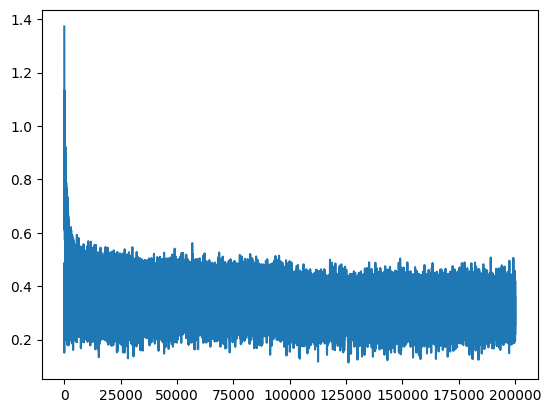

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1113, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1613, grad_fn=<NllLossBackward0>)

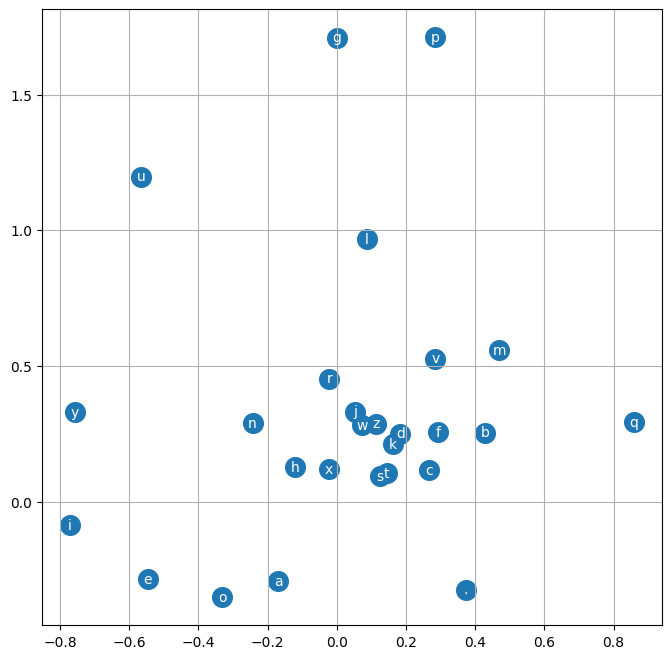

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
kayanniellend.
ryla.
remmadiendraj.
cadered.
eliah.
miloparetelleananaraelyzimankelin.
shrusrishimier.
kindreelynn.
nopucayzon.
teda.
jamelizeko.
kayshuston.
mahil.
calynn.
khazaril.
julen.
crevis.
jaisley.
adi.
